## Obtain monthly T200 along 15°C isotherm using EN4

In [1]:
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm,gridspec,colors,rc
import matplotlib as mpl
import zhuomin_2new_tools
import cmcrameri.cm as cmc

In [2]:
# EN4 T200: 1954.01-2024.09
path = '/glade/work/czhuomin/MAPP/CMEMS/DATA'
filename = f'{path}/EN4_T200_monthly_1954-2024.nc'
ds = xr.open_dataset(filename)
T200_EN4 = ds['T200'][:(2024-1954)*12+9,:,:].values # nmon,nlat,nlon
#T200_EN4 = ds['T200'][(1993-1954)*12:(2020-1954)*12,:,:].values # nmon,nlat,nlon
#T185_EN4 = ds['T185'][(1993-1954)*12:(2020-1954)*12,:,:].values # nmon,nlat,nlon
#T207_EN4 = ds['T207'][(1993-1954)*12:(2020-1954)*12,:,:].values # nmon,nlat,nlon
lat_EN4 = ds['lat'][:].values
lon_EN4 = ds['lon'][:].values
ds.close()

In [3]:
# calculate climatological mean T200 from 1954.01 to 2023.12
T200_EN4_mean = T200_EN4.mean(axis=0) # nlat,nlon
# select grid points between 74° and 55° W
loc1 = np.where(np.abs(lon_EN4 - (-74)) < 1e-2)[0][0]
loc2 = np.where(np.abs(lon_EN4 - (-55)) < 1e-1)[0][0]
po_lon = lon_EN4[loc1:loc2+1]
print(po_lon)

[-74. -73. -72. -71. -70. -69. -68. -67. -66. -65. -64. -63. -62. -61.
 -60. -59. -58. -57. -56. -55.]


/glade/u/home/czhuomin/.local/lib/python3.7/site-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


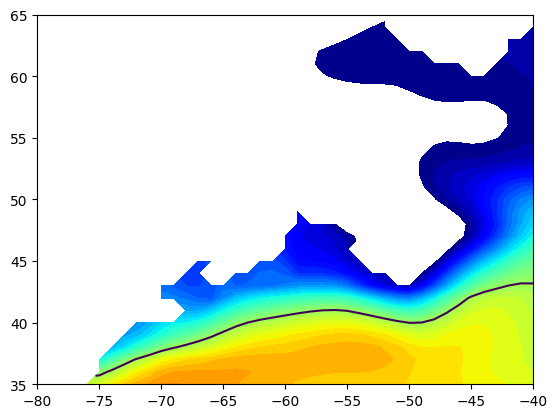

In [4]:
# plot the 15°C isotherm at 200-m depth
dlon, dlat = np.meshgrid(lon_EN4, lat_EN4)
plt.contourf(dlon, dlat, T200_EN4_mean, np.arange(4, 25, 0.5), cmap=cm.jet)
ch = plt.contour(dlon, dlat, T200_EN4_mean, [15])
segs = ch.allsegs[0]
newseg = segs[0]
newseg = newseg[::-1]
plt.show()

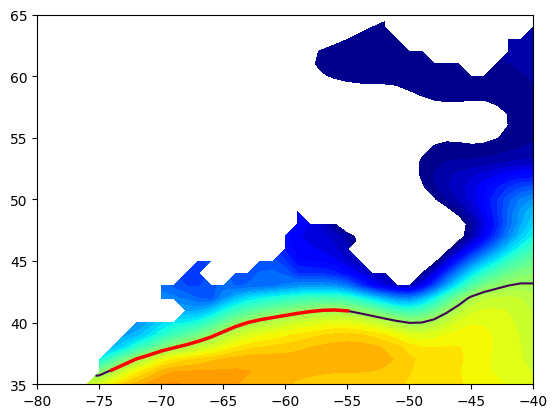

In [5]:
loc = []
for hh in range(len(po_lon)):
    ll = np.where(np.abs(newseg[:,0] - po_lon[hh]) < 1e-4)[0][0]
    loc.append(ll)
#
newseg = newseg[loc]
po_lon = newseg[:,0]
po_lat = newseg[:,1]
#
plt.contourf(dlon, dlat, T200_EN4_mean, np.arange(4, 25, 0.5), cmap=cm.jet)
ch = plt.contour(dlon, dlat, T200_EN4_mean, [15])
plt.plot(po_lon, po_lat, color='r', lw=2.5)
plt.show()

In [6]:
# save to file
dsf = xr.Dataset()
dsf['po_lon'] = po_lon
dsf['po_lat'] = po_lat
dsf.load()

<xarray.Dataset>
Dimensions:  (po_lon: 20, po_lat: 20)
Coordinates:
  * po_lon   (po_lon) float64 -74.0 -73.0 -72.0 -71.0 ... -57.0 -56.0 -55.0
  * po_lat   (po_lat) float64 36.15 36.61 37.06 37.37 ... 40.9 41.0 41.03 40.96
Data variables:
    *empty*

In [7]:
outpath = '/glade/work/czhuomin/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/EN4_T200_15_degC_lon_lat.nc', mode='w')

### obtain the selected points' T200 time series

In [8]:
T_po = np.ma.zeros([len(po_lon), np.shape(T200_EN4)[0]]); T_po.mask = True
for ii in range(len(po_lon)):
    loni = np.where(lon_EN4==po_lon[ii])[0][0]
    lati = np.where(lat_EN4==np.floor(po_lat[ii]))[0][0]
    #
    T_po[ii,:] = T200_EN4[:,lati,loni] + (po_lat[ii]-np.floor(po_lat[ii]))*(T200_EN4[:,lati+1,loni]-T200_EN4[:,lati,loni])/(np.ceil(po_lat[ii])-np.floor(po_lat[ii]))

In [9]:
# remove seasonal climatology
#T_po = T_po.reshape([len(po_lon), np.floor(np.shape(T200_EN4)[0]/12), 12])
T_po_c = T_po[:, (1954-1954)*12:(2018-1954)*12].reshape([len(po_lon), 2018-1954, 12]).mean(axis=1) # 1954-2018
T_po_c = np.tile(T_po_c[:, np.newaxis, :], [1, 2025-1954, 1]).reshape([len(po_lon), (2025-1954)*12])
T_po = T_po - T_po_c[:, :np.shape(T200_EN4)[0]]

In [10]:
# save to file
dsf = xr.Dataset()
dsf['T_po'] = xr.DataArray(data=T_po,coords=dict(npo=('npo',range(len(po_lon))),nmon=('nmon',range(np.shape(T200_EN4)[0]))),dims=('npo','nmon'))
dsf['po_lon'] = po_lon
dsf['po_lat'] = po_lat
dsf.load()
outpath = '/glade/work/czhuomin/MAPP/CMEMS/DATA'
dsf.to_netcdf(f'{outpath}/EN4_20points_T200_time_series_1954.01-2024.09.nc', mode='w')